<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/nn_on_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network on MNIST dataset

Solving the MNIST is a benchmark for machine learning models.

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/mnist.png?raw=true">

The MNIST database (modified National Institute of Standards of Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.

The MNIST database contains 60,000 training images and 10,000 testing images.



## Introduction to Torchvision

**Torchvision** is a package contining popular datasets, model architectures and common image transformations for computer vision

<br/>

**Datasets**

Many popular and common **datasets** are incuded out of the box, like MNIST, ImageNet, CIFAR. (For full refrence: https://pytorch.org/vision/main/datasets.html.) All these datasets inherit from teh original `Dataset` class, so that can be nautrally used with a DataLoader in exactly the same way like custom Dataset

**Models**

PyTorch also includes the most popular model architecture, including their pre-trained weights, for tackling many tasks like image classification, semantic segmentation, object detection, instance segmentation, person keypoint detection and video classication.

Well-known models include AlexNet, VGG, ResNet etc.

**Transforms**

Torchvision has some common image transformation in its `transforms` module. There are 2 main groups of transformations

1. Transformations based on images (in either PIL or PyTorch shapes)
2. Transformations based on Tensors

The conversion transforms to convert from tensor `ToPILImage()` and from PIL image `ToTensor()`



## Downloading MNIST Dataset

PyTorch domain libraries provides a number of pre-loaded datasets under `torchvision.datasets`
Referece: https://pytorch.org/vision/main/datasets.html

To download it, we will need ot provide the following parameters

*   **root (str or pathlib.Path)**

    Root directory of dataset where MNIST/raw/train-images-idx3-ubyte and MNIST/raw/t10k-images-idx3-ubyte exist.

*   **train (bool, optional)**

    If True, creates dataset from train-images-idx3-ubyte, otherwise from t10k-images-idx3-ubyte.

*   **download (bool, optional)**

    If True, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.

*   **transform (callable, optional)**

    A function/transform that takes in a PIL image and returns a transformed version. E.g, transforms.RandomCrop

*   **target_transform (callable, optional)**

    A function/transform that takes in the target and transforms it.

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Setup train_ds and valid_ds
train_ds = MNIST(root='data',
                 train=True,
                 download=True,
                 transform=ToTensor(),
                 target_transform=None)

valid_ds = MNIST(root='data',
                 train=False,
                 download=True,
                 transform=ToTensor(),
                 target_transform=None)

100%|██████████| 9912422/9912422 [05:01<00:00, 32824.25it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 441434.09it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 1500526.34it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4912462.29it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Exploring the MNIST Dataset

Checking the length of dataset

In [ ]:
len(train_ds), len(valid_ds)

(60000, 10000)

The MNIST database contains 60,000 training images and 10,000 testing images.

Getting a single datapoint from `train_ds`

In [2]:
img, label = train_ds[0]

Above shows tensor of img and a single value for a target(label)

In [ ]:
img.shape

torch.Size([1, 28, 28])

The shape of the image tensor is [1, 28, 28] which is of [color_channels=1, height=28, width=28]

Having `color_channels=1` means the image is grayscale. If `color_channels=3`, the image comes in pixel values for red, green and blue, known as the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model)

PyTorch accepts `NCHW (channel first) as the default for many operations.

* **N** stands for Number of images (in a mini-batch)
* **C** stands for number of Channels (or filters) in each image
* **H** stands for each images Height
* **W** stands for each image Width

Note that different packages/framwork can use different convention

*  PyTorch uses **NCHW**
*  TensorFlow uses **NHWC**
*  PIL images are **HWC**
*  OpenCV images uses **NCHW** but with **BGR** instead of **RGB** as default

## Visualizing our data

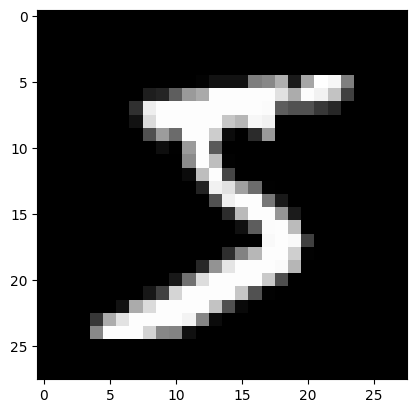

In [ ]:
import matplotlib.pyplot as plt
# Use squeeze() to turn image shape to [28, 28]
# turn to greyscale by using cmap='gray'
plt.imshow(img.squeeze(dim=0), cmap='gray');

## Prepare DataLoader for MNIST Dataset

We will need to turn our train_ds and valid_ds into DataLoader for training.

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(dataset=train_ds,
                      batch_size=32,
                      shuffle=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=32,
                      shuffle=False)

## Visualise a batch to validate the DataLoaders

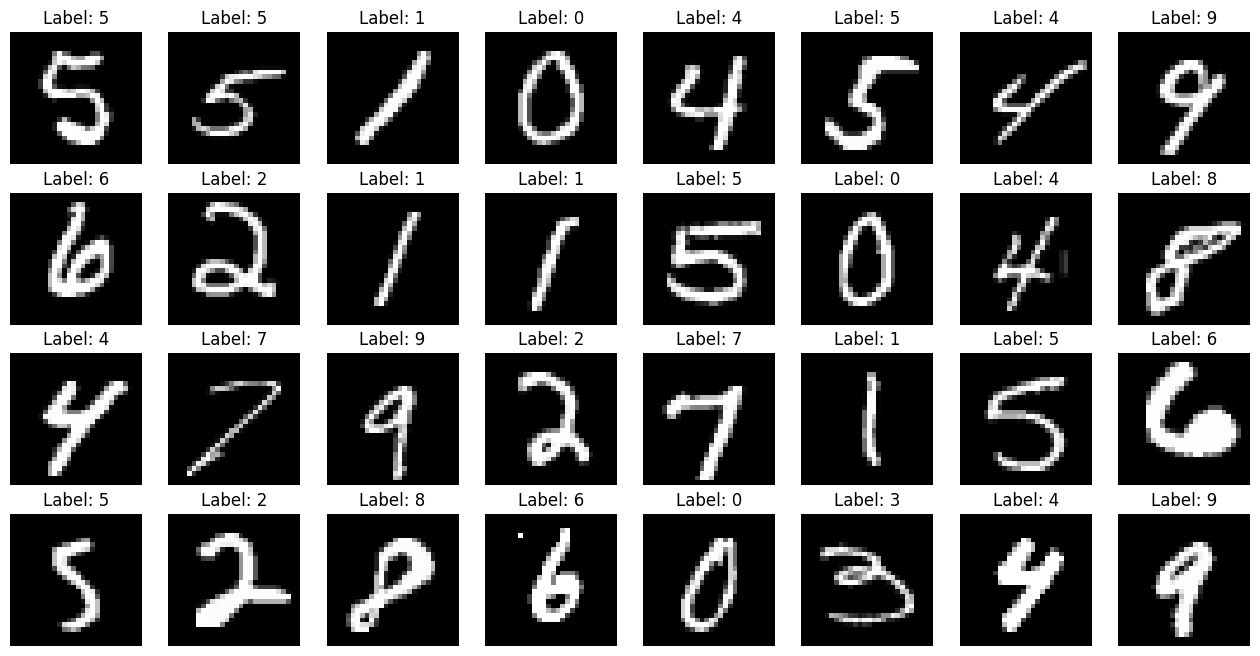

In [ ]:
images, labels = next(iter(train_dl))

fig = plt.figure(figsize=(16, 8))
rows, cols = 4, 8
for i in range(rows * cols):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis(False);

## Setting up loss_fn and metric_fn

For multi-class classification, we will setup
* nn.CrossEntropyLoss() as `loss_fn`

    **Cross-Entropy Loss** is a loss function that is commonly used to quantify the difference between 2 probabilities distribution.

    where p(x) is the output probability and q(x) is the true probability


$$
H(p, q)=-\sum_x p(x) \log q(x) .
$$

<br/>

* macro Average on Accuracy, Precision, Recall and F1 for `metric_fn`

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

$$
{Precision}_{macro}=\frac{1}{n}\sum_{t=1}^n \frac{{TP}_i}{{TP}_i + {FP}_i}
$$

$$
{Recall}_{macro}=\frac{1}{n}\sum_{t=1}^n \frac{{TP}_i}{{TP}_i + {FN}_i}
$$

$$
{F1score}_{macro}=2 \times \frac{{Precision}_{macro} * {Recall}_{macro}}{{Precision}_{macro} + {Recall}_{macro}}
$$



In [ ]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def metric_fn(y_logits, y):
    """ Return dictionary of metrics of accuracy_score, precision_score, recall_score and f1_score
    """
    # Make prediction using argmax and turn into numpy array
    y_preds = torch.argmax(y_logits, dim=-1).detach().cpu().numpy()
    y = y.detach().cpu().numpy()

    # Calculate scores from using sklearn.metrics
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds, average='macro', zero_division=0)
    recall = recall_score(y, y_preds, average='macro', zero_division=0)
    f1 = f1_score(y, y_preds, average='macro', zero_division=0)

    # SSTLearner supports returning a dictionary from metric_fn
    return {'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1}

metric_fn

<function __main__.metric_fn(y_logits, y)>

## Model 0 - Baseline Linear Regression

We will create a baseline model by subclassing `nn.Module` which consists of 2

In [ ]:
class Model0(nn.Module):
    def __init__(self, in_features, hidden_units, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=out_features)
        )
    def forward(self, X):
        return self.linear_layer(X)

We will set the following parameters

*  `input_features=784` - it is the flattened pixel 28x28 going into the model
*  `hidden_units=10` - neurals to be set in fully connected hidden layers
*  `out_features=10` - num of classes for multi-class classification [0-9]

## Testing out the model_0 using 1 batch

In [ ]:
model_0 = Model0(in_features=784, hidden_units=10, out_features=10)

In [ ]:
# Trying out a batch to model
X, y = next(iter(train_dl))
y_logits = model_0(X)

In [ ]:
y_logits.shape

torch.Size([32, 10])

Output of the model is of shape [batch_size, num_of_classes]

---



In [ ]:
# Trying out loss_fn
loss_fn(y_logits, y)

tensor(2.3399, grad_fn=<NllLossBackward0>)

In [ ]:
# Trying out metric_fn
metric_fn(y_logits, y)

{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

## Importing SSTLearner for training

In [ ]:
# Installing sstorch package
!pip -q install git+https://github.com/ronald-hk-chung/sstorch.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 10.7 MB/s eta 0:00:00


## Training the baseline model_0

In [ ]:
from sstorch.learner import SSTLearner

model_0_learner = SSTLearner(model=model_0,
                             loss_fn=loss_fn,
                             metric_fn=metric_fn,
                             optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.1),
                             train_dataloader=train_dl,
                             valid_dataloader=valid_dl)

To check the model info using torchinfo

In [ ]:
model_0_learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Model0 (Model0)                          [32, 1, 28, 28]      [32, 10]             --                   True
├─Sequential (linear_layer)              [32, 1, 28, 28]      [32, 10]             --                   True
│    └─Flatten (0)                       [32, 1, 28, 28]      [32, 784]            --                   --
│    └─Linear (1)                        [32, 784]            [32, 10]             7,850                True
│    └─Linear (2)                        [32, 10]             [32, 10]             110                  True
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.14


In [ ]:
model_0_learner.train(5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-01 | train_loss: 0.406 | valid_loss: 0.323 
train_metric: {'accuracy': 0.885, 'precision': 0.872, 'recall': 0.873, 'f1': 0.856}
valid_metric: {'accuracy': 0.908, 'precision': 0.898, 'recall': 0.897, 'f1': 0.883}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-01 | train_loss: 0.309 | valid_loss: 0.285 
train_metric: {'accuracy': 0.911, 'precision': 0.902, 'recall': 0.901, 'f1': 0.888}
valid_metric: {'accuracy': 0.919, 'precision': 0.911, 'recall': 0.909, 'f1': 0.897}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-01 | train_loss: 0.296 | valid_loss: 0.283 
train_metric: {'accuracy': 0.917, 'precision': 0.908, 'recall': 0.907, 'f1': 0.895}
valid_metric: {'accuracy': 0.92, 'precision': 0.915, 'recall': 0.912, 'f1': 0.901}
----------------------------------------------------------------------------------------------------
Ep

Our baseline model works. It is predicting wiht a valid accuracy of ~92% which is not bad for a linear regression model. But to further improve the accuracy, we will need to add non-linearity activation function to make our model deep.

## Model 1 - Multi-Layer Neural Network with non-linear activation function

Note that despite model_0 having 2 linear layers, it is still a shallow model since there is no activation function for non-linearity. IN order ot improve our model, we will add non-linearly activation function in between outputs of the hidden layers.



## Chosing an Activation Function

**Activation Function** are nonlinear functions that squash or bend straights line. Together wtih added dimensionality in the hidden layers, it enables transformation of feature spaces that allow the model to figure ourt a way of seperating the data.

Technically, we can use any function as an activation function in multilayer NNs as long as it is differentiable. Below are some common activation functions available in PyTorch





To visualize activation functions and its gradient.

In [ ]:
def plot_activation(func, name=None):
    z = torch.linspace(-5, 5, 1000)
    z.requires_grad_(True)
    func(z).sum().backward()
    sig = func(z).detach()

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    title = func.__name__ if name is None else name
    ax.set_title(title)
    ax.plot(z.detach().numpy(), sig.numpy(), c='k', label='Activation')
    ax.plot(z.detach().numpy(), z.grad.numpy(), c='r', label='Gradient')
    ax.grid()
    ax.legend();

### **Sigmoid**

Sigmoid is the most traditional of the action functions, derived from log odds probabilities to transform logits into probabilities.

$$
\sigma(z)=\frac{1}{1+e^{-z}}
$$

The sigmoid activation function "squashes" its input values(z) into range(0, 1). Gradient peak value is only 0.25 and its gets close to zero as the absolute value of z reaches a value of 5

Note also that Sigmoid activation values are going to be centered around 0.5 instead of 0. It means that, even if we normalize our inputs to feed the first layer, it will not be the case anymore for the other layers.

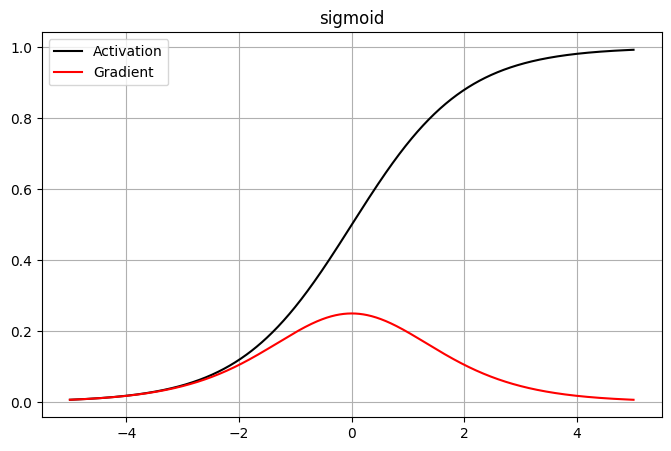

In [ ]:
plot_activation(torch.sigmoid)

### **Hyperbolic Tangent (TanH)**

The **hyperbolic tangent activation function** was the evolution of the sigmoid which broaden the output spectrum with a zero mean.

$$
\sigma(z) = \frac{e^z-e^{-z}}{e^z + e^{-z}}
$$

the **TanH acviation function** transforms the input value into the range (-1, 1) and ensure it entered at zero which normalized inputs for hte next layer, making the TanH activation function better than sigmoid

Gradient also has much larger peak value of 1.0 at (z=0), but decrease is even faster, approaching zero to absolute values of z as low as 3 which will led to vanishing gradients problem that causes slow training.

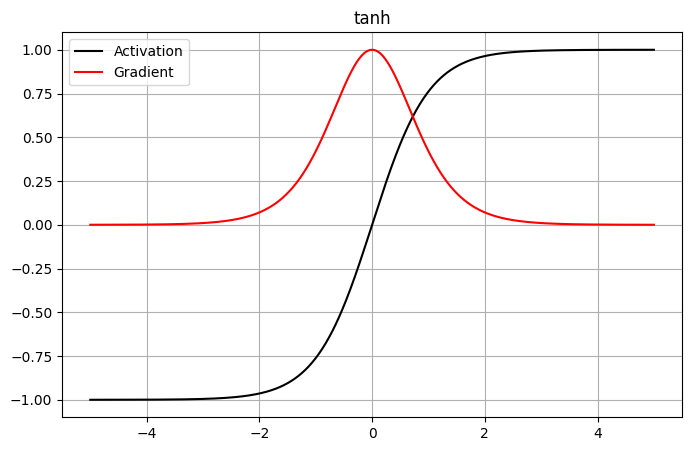

In [ ]:
plot_activation(torch.tanh)

### **Rectified Linear Unit (ReLU)**

**ReLU** activation function address the vanishing gradient issue by using an avtivation that bends.

$$
z = \begin{cases}
z &\text{if } z\geq0 \\
0 &\text{if } z<0
\end{cases}
$$

<p align='center'>or</p>

$$
\sigma(z)=\max(0, z)
$$

**ReLU** simply preserves positive values and turns all negative values into zero. The upside of using a **ReLU** is that its gradient is either one (for positive value) or zero (for negative values) with no more vanishing gradients which leads to a faster convergence of the network. The downside is that it can lead to **dead neuron** whose input are consistently negative and have activation value of zero.

For deeper and more complex models, **ReLU** can lead to **internal covariate shift** - different distributions of activation values in different layers which can be address by using normalization layers such as `nn.BatchNorm`



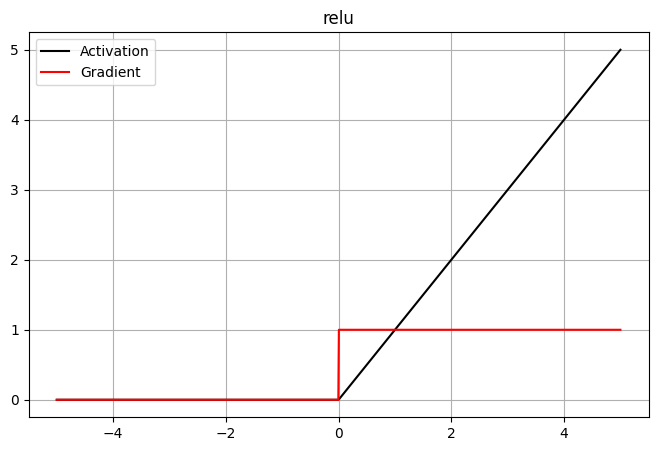

In [ ]:
plot_activation(torch.relu)

### **Leaky ReLU**

**Leaky ReLU** retusn a tiny activation value and yields a tiny gradient to try overcoming the **dead neuron** problem by giving them a chance to get unstuck. It keeps all the nice properties of the **ReLU** - large gradients and faster convergence

$$
z = \begin{cases}
z &\text{if } z\geq0 \\
0.01z &\text{if } z<0
\end{cases}
$$

<p align='center'>or</p>

$$
\sigma(z)=\max(0, z) + 0.01 \min(0,z)
$$

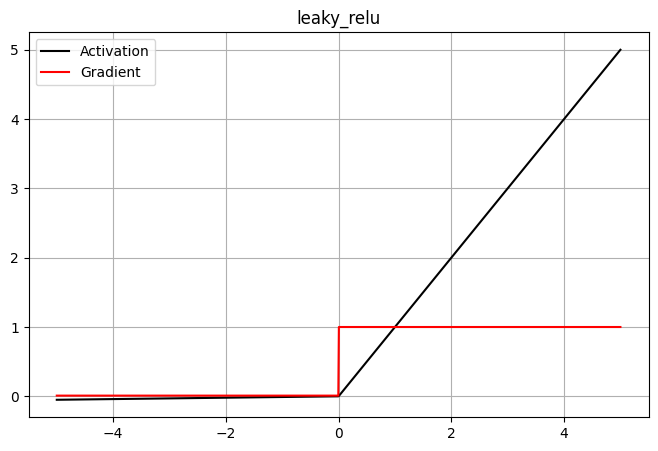

In [ ]:
plot_activation(nn.functional.leaky_relu)

### **Parametric ReLU (PReLU)**

**PReLU** is a natural evolution which parameterise (a) the coefficient of leakage.

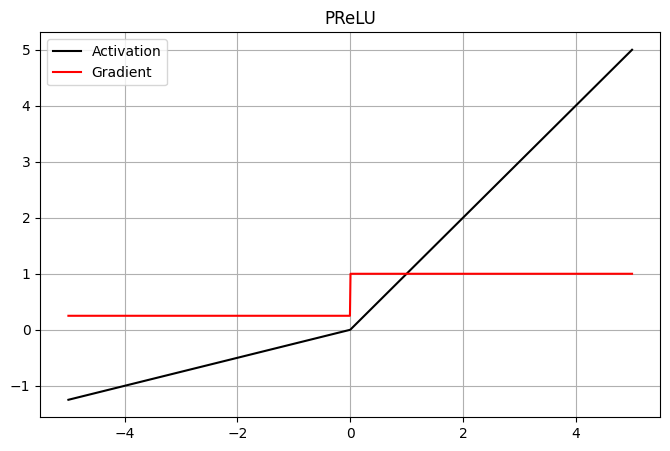

In [ ]:
plot_activation(nn.PReLU(), 'PReLU')

## Building model_1

In [ ]:
class Model1(nn.Module):
    def __init__(self, in_features, hidden_units, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=out_features),
            nn.ReLU()
        )
    def forward(self, X):
        return self.linear_layer(X)

In [ ]:
model_1 = Model1(in_features=784, hidden_units=10, out_features=10)

In [ ]:
model_1_learner = SSTLearner(model=model_1,
                             loss_fn=loss_fn,
                             metric_fn=metric_fn,
                             optimizer=torch.optim.SGD(params=model_1.parameters(), lr=0.1),
                             train_dataloader=train_dl,
                             valid_dataloader=valid_dl)

In [ ]:
model_1_learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Model1 (Model1)                          [32, 1, 28, 28]      [32, 10]             --                   True
├─Sequential (linear_layer)              [32, 1, 28, 28]      [32, 10]             --                   True
│    └─Flatten (0)                       [32, 1, 28, 28]      [32, 784]            --                   --
│    └─Linear (1)                        [32, 784]            [32, 10]             7,850                True
│    └─ReLU (2)                          [32, 10]             [32, 10]             --                   --
│    └─Linear (3)                        [32, 10]             [32, 10]             110                  True
│    └─ReLU (4)                          [32, 10]             [32, 10]             --                   --
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.10
Forward/backw

In [ ]:
model_1_learner.train(5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-01 | train_loss: 1.207 | valid_loss: 1.128 
train_metric: {'accuracy': 0.548, 'precision': 0.402, 'recall': 0.543, 'f1': 0.435}
valid_metric: {'accuracy': 0.557, 'precision': 0.437, 'recall': 0.554, 'f1': 0.46}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-01 | train_loss: 0.918 | valid_loss: 0.747 
train_metric: {'accuracy': 0.661, 'precision': 0.546, 'recall': 0.655, 'f1': 0.571}
valid_metric: {'accuracy': 0.727, 'precision': 0.635, 'recall': 0.725, 'f1': 0.653}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-01 | train_loss: 0.737 | valid_loss: 0.748 
train_metric: {'accuracy': 0.729, 'precision': 0.633, 'recall': 0.727, 'f1': 0.654}
valid_metric: {'accuracy': 0.72, 'precision': 0.635, 'recall': 0.723, 'f1': 0.649}
----------------------------------------------------------------------------------------------------
Epo

It is interesting to see adding non-linearities to model made it perform worse than the baseline. It is because model is overfitting on the training data.

## Convolutional Neural Network - The winning solution for MNIST Dataset

Note that our Multinomial logistic regression in the simple attempts score ~92% which is inline with the results in Kaggle leaderboard scores

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/KaggleMNIST.png?raw=true">

The top 98%+ accuracy all requires a simple **Convolutional Neural Network**




## Brief Explanation for **Convsolutional Neural Network (CNN)**

Full Reference: https://poloclub.github.io/cnn-explainer/

### **Typical Architecture of Convolutional blocks**

A typical architecture uses a sequence of one or more typical convolutional blocks, with each block consiting of 3 options:

1. Convolutional Layers
2. Activation function
3. Pooling

### **Convolutional Layers - Convolving**

A convolution is a mathematical operation on two functions $f$ and $g$ that produces a third function $f*g$ expressing how the shape of one is modified by the other. In image processing, a **convolutiona matrix** is also called a **kernel**. Typical image processing operations - like blurring, sharpening, edge detection and more are accomplished by performing a convolution between a kernal and an image. Convolutional layers contain the learned kernels (filters with weights) act as **feature extractors** that distinguih different images from one another.

The convolutional neuron performs an elementwise dot product with a unique kernel and the output of the previous layer's corresponding neuron.

Reference: https://arxiv.org/abs/1603.07285

Below shows the mathematical operations behind **Convolving**:

For a discrete filter:

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/conv_filter.png?raw=true">

We can then move around the filter for a single channel image

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/conv_no_padding_no_strides.gif?raw=true">

<br/>

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/conv_operation.PNG?raw=true">


Note that applying a kernal(filter) will always produce a single value, the reduction is qual to the filter size - 1, that is

$$
(h_r, w_r) = (h_i - (h_f-1), w_i - (w_f-1))
$$

For above example
$$
(h_r, w_r) = (5-(3-1), 5-(3-1))=(3, 3)
$$

This will yield as many intermediate results as they are unique kernels. The convolutional neuron is the result of all of the intermediate results summed together with the learned bias.


Convolutions in PyTorch comes in 2 flavors:

1. The **functional** convolution takes the **kernel** as an argument
2. The **module** has learnable weights to represent the **kernel**


In [ ]:
import torch
import torch.nn.functional as F

image = torch.tensor([[[[3,3,2,1,0],
                      [0,0,1,3,1],
                      [3,1,2,2,3],
                      [2,0,0,2,2],
                      [2,0,0,0,1]]]])
print(f'image size: {image.shape}')

kernel = torch.tensor([[[[0, 1, 2],
                       [2, 2, 0],
                       [0, 1, 2]]]])
print(f'kernel size: {kernel.shape}')

convolved = F.conv2d(image, kernel, stride=1)
print(f'convolved size: {convolved.shape}')
print(convolved)

image size: torch.Size([1, 1, 5, 5])
kernel size: torch.Size([1, 1, 3, 3])
convolved size: torch.Size([1, 1, 3, 3])
tensor([[[[12, 12, 17],
          [10, 17, 19],
          [ 9,  6, 14]]]])


### **Convolutional Layers - Hyperparameters**

PyTorch convolutional module `nn.Conv2d` has below arguments:

* `in_channels` (int) - Number of channels in the input image
* `out_channels` (int) - Number of channels produced by the convolution
* `kernel_size` (int or tuple) - Size of the convolving kernel
* `stride` (int or tuple, optional) - Stride of the convolution, Default 1
* `padding` (int, tuple or str, optional) - Padding added to all four sides of the input. Default 0
* `padding_mode` (str, optional) - 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zero'
* `dilation` (int or tuple, optional) - Spacing between kernel elements. Default 1
* `groups` (int, optional) - Number of blocked connections from input channels to output channels. Default 1
* `bias` (bool, optional) - If True, adds a learnable bias to the output. Default True

<br/>

1. **Padding** is often necessary when the kernel extends beyond the activation map. Padding conserves data at the borders of activation maps, which leads to better performance, and it can help preserve the input's spatial size, which allows an architecture designer to build deeper, higher performing networks. There exist many padding techniques, but the most commonly used approach is zero-padding because of its performance, simplicity, and computational efficiency. The technique involves adding zeros symmetrically around the edges of an input. This approach is adopted by many high-performing CNNs such as AlexNet.

2. **Kernel size**, often also referred to as filter size, refers to the dimensions of the sliding window over the input. Choosing this hyperparameter has a massive impact on the image classification task. For example, small kernel sizes are able to extract a much larger amount of information containing highly local features from the input. As you can see on the visualization below, a smaller kernel size also leads to a smaller reduction in layer dimensions, which allows for a deeper architecture. Conversely, a large kernel size extracts less information, which leads to a faster reduction in layer dimensions, often leading to worse performance. Large kernels are better suited to extract features that are larger. At the end of the day, choosing an appropriate kernel size will be dependent on your task and dataset, but generally, smaller kernel sizes lead to better performance for the image classification task because an architecture designer is able to stack more and more layers together to learn more and more complex features!

3. **Stride** indicates how many pixels the kernel should be shifted over at a time. For example, as described in the convolutional layer example above, Tiny VGG uses a stride of 1 for its convolutional layers, which means that the dot product is performed on a 3x3 window of the input to yield an output value, then is shifted to the right by one pixel for every subsequent operation. The impact stride has on a CNN is similar to kernel size. As stride is decreased, more features are learned because more data is extracted, which also leads to larger output layers. On the contrary, as stride is increased, this leads to more limited feature extraction and smaller output layer dimensions. One responsibility of the architecture designer is to ensure that the kernel slides across the input symmetrically when implementing a CNN. Use the hyperparameter visualization above to alter stride on various input/kernel dimensions to understand this constraint!

<!--
### Convolution animations

_N.B.: Blue maps are inputs, and cyan maps are outputs._

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer-vision/assets/conv_no_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer-vision/assets/conv_arbitrary_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer-vision/assets/conv_same_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer-vision/assets/conv_full_padding_no_strides.gif?raw=true"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer-vision/assets/conv_no_padding_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer-vision/assets/conv_padding_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer-vision/assets/conv_padding_strides_odd.gif?raw=true"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td></td>
  </tr>
</table> -->

### **Convolutional Layers - Shape**

The output size of a convolution is determined by the total number of times that we shift the filter, $w$, along th input vector. Let's assume that the input vector is of size $n$ and the kernel is of size $m%=$,. Then the size of the output $o$ resulting from $y=x*w$, with padding $p$ and stride $s$, woudl be determined as follows:

$$
o = \lfloor \frac{n+2p-m}{s} \rfloor + 1
$$



### **Activation Layer**

Part of the reason CNNs manage to have groundbreaking accuracies is because of their non-linearity. ReLU applies much-needed non-linearity into the model. Non-linearity is necessary to produce non-linear decision boundaries, so that the output cannot be written as a linear combination of the inputs. If a non-linear activation function was not present, deep CNN architectures would devolve into a single, equivalent convolutional layer, which would not perform nearly as well. The ReLU activation function is specifically used as a non-linear activation function, as opposed to other non-linear functions such as Sigmoid because it has been empirically observed that CNNs using ReLU are faster to train than their counterparts.

This activation function is applied elementwise on every value from the input tensor. The Rectified Linear Activation function (ReLU) is performed after every convolutional layer in the network architecture outlined below.

### **Pooling Layers**

Pooling Layers
There are many types of pooling layers in different CNN architectures, but they all have the purpose of gradually decreasing the spatial extent of the network, which reduces the parameters and overall computation of the network. The type of pooling used in the Tiny VGG architecture above is Max-Pooling.

The Max-Pooling operation requires selecting a kernel size and a stride length during architecture design. Once selected, the operation slides the kernel with the specified stride over the input while only selecting the largest value at each kernel slice from the input to yield a value for the output. This process can be viewed by clicking a pooling neuron in the network above.

Belows shows an operation for max pooling:

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/max_pooling.png?raw=true">

In [ ]:
image = torch.tensor([[[[3,3,2,1,0],
                      [0,0,1,3,1],
                      [3,1,2,2,3],
                      [2,0,0,2,2],
                      [2,0,0,0,1]]]])

maxpool = nn.MaxPool2d(kernel_size=3, stride=1)

maxpool_image = maxpool(image)
print(maxpool_image)

tensor([[[[3, 3, 3],
          [3, 3, 3],
          [3, 2, 3]]]])



In the Tiny VGG architecture above, the pooling layers use a 2x2 kernel and a stride of 2. This operation with these specifications results in the discarding of 75% of activations. By discarding so many values, Tiny VGG is more computationally efficient and avoids overfitting.

### Putting it all together

We will use `nn.Sequential` to construct convolution block that contains

1. Convolution Layer `nn.Conv2d`
2. Activation Function `nn.ReLU`
3. Pooling Layer `nn.MaxPool2d`

As images go through these operations, they will shrink in size. After 2 of these blocks (assuming kernel size of 2 for pooling), for instance, an image will be reduced by 1/8 or less of its original dimensions. The number of channels/filters produced by each block usually increases as more blocks are added.

After the sequence of blocks, the image gets flattened. And hopefully, at this stage there is no loss of information occuring by considering each value in the flattened tensor a feature on its own. As the features dissociated from pixels, it becomes a standard classification problem with a classifier layer outputting logits for classification.



## Building TinyVGG model to solve MNIST

Reference: https://cs231n.stanford.edu/

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/tinyvgg.png?raw=true">

In [ ]:
from collections import OrderedDict

class TinyVGG(nn.Module):
    def __init__(self, in_channels, hidden_units, out_channels):
        super().__init__()
        self.conv_block_1 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=in_channels,
                                out_channels=hidden_units,
                                kernel_size=3,
                                stride=1,
                                padding=1)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(in_channels=hidden_units,
                                out_channels=hidden_units,
                                kernel_size=3,
                                stride=1,
                                padding=1)),
            ('relu2', nn.ReLU()),
            ('maxpool', nn.MaxPool2d(kernel_size=2))
        ]))
        self.conv_block_2 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=hidden_units,
                                out_channels=hidden_units,
                                kernel_size=3,
                                stride=1,
                                padding=1)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(in_channels=hidden_units,
                                out_channels=hidden_units,
                                kernel_size=3,
                                stride=1,
                                padding=1)),
            ('relu2', nn.ReLU()),
            ('maxpool', nn.MaxPool2d(kernel_size=2))
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('flattener', nn.Flatten()),
            ('linear', nn.LazyLinear(out_features=out_channels))
        ]))

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [ ]:
model_2 = TinyVGG(in_channels=1,
                  hidden_units=10,
                  out_channels=10)

Note that we will either need to calculate the output of the flattened tensor by going through the Conv2d block or using a `nn.LazyLinear` to pass through the network to infer the in_features

To calculate the size of `conv_block`

$$
o=(\lfloor\frac{n +2p-k_c}{s}\rfloor+1) / k_p
$$


In [ ]:
from math import floor

n = 28  # input size
k_c = 3   # kernel size
p = 1   # padding
k_p = 2 # maxpool layer kernel size
s = 1   # stride
hidden_units = 10

o_1 = (floor((n + 2*p - k_c)/s) + s) / k_p
print(f'conv_block_1 output: {o_1}')
o_2 = (floor((o_1 + 2*p - k_c)/s) + s) / k_p
print(f'conv_block_2 output: {o_2}')
f = hidden_units * o_2 * o_2
print(f'flattened length: {f}')

conv_block_1 output: 14.0
conv_block_2 output: 7.0
flattened length: 490.0


Set up SSTLearner for model_2

In [ ]:
model_2_learner = SSTLearner(model=model_2,
                             loss_fn=loss_fn,
                             metric_fn=metric_fn,
                             optimizer=torch.optim.SGD(params=model_2.parameters(), lr=0.1),
                             train_dataloader=train_dl,
                             valid_dataloader=valid_dl)

In [ ]:
model_2_learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyVGG (TinyVGG)                        [32, 1, 28, 28]      [32, 10]             --                   True
├─Sequential (conv_block_1)              [32, 1, 28, 28]      [32, 10, 14, 14]     --                   True
│    └─Conv2d (conv1)                    [32, 1, 28, 28]      [32, 10, 28, 28]     100                  True
│    └─ReLU (relu1)                      [32, 10, 28, 28]     [32, 10, 28, 28]     --                   --
│    └─Conv2d (conv2)                    [32, 10, 28, 28]     [32, 10, 28, 28]     910                  True
│    └─ReLU (relu2)                      [32, 10, 28, 28]     [32, 10, 28, 28]     --                   --
│    └─MaxPool2d (maxpool)               [32, 10, 28, 28]     [32, 10, 14, 14]     --                   --
├─Sequential (conv_block_2)              [32, 10, 14, 14]     [32, 10, 7, 7]       --                   True
│    └─Conv2d (conv1

In [ ]:
model_2_learner.train(5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 | LR: 1.0E-01 | train_loss: 0.042 | valid_loss: 0.041 
train_metric: {'accuracy': 0.987, 'precision': 0.985, 'recall': 0.985, 'f1': 0.983}
valid_metric: {'accuracy': 0.986, 'precision': 0.985, 'recall': 0.985, 'f1': 0.982}
----------------------------------------------------------------------------------------------------
Epoch: 7 | LR: 1.0E-01 | train_loss: 0.037 | valid_loss: 0.042 
train_metric: {'accuracy': 0.988, 'precision': 0.986, 'recall': 0.986, 'f1': 0.984}
valid_metric: {'accuracy': 0.987, 'precision': 0.985, 'recall': 0.984, 'f1': 0.982}
----------------------------------------------------------------------------------------------------
Epoch: 8 | LR: 1.0E-01 | train_loss: 0.035 | valid_loss: 0.035 
train_metric: {'accuracy': 0.989, 'precision': 0.987, 'recall': 0.987, 'f1': 0.985}
valid_metric: {'accuracy': 0.989, 'precision': 0.988, 'recall': 0.987, 'f1': 0.986}
----------------------------------------------------------------------------------------------------
E

We achieved ~99% (close to top 35% of kaggle competition) with 10 epochs

## Evaluate our model

To evaluate our model, we first def `make_predictions` to generate the probabilities for full valid_ds

In [ ]:
def make_predictions(model, data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data:
            # Forward pass -> logits
            y_logits = model(X.unsqueeze(0).to(device))
            # Calculate Probabilities (logits -> prediction probabilities)
            y_probs = y_logits.squeeze(0).softmax(0)
            # Append as CPU
            pred_probs.append(y_probs.cpu())

    probs, preds = torch.stack(pred_probs).max(1)
    return probs, preds

In [ ]:
# Make Full predictions that return probs (probability of prediction) and preds (predictions)
probs, preds = make_predictions(model_2, valid_ds)
probs.shape, preds.shape

(torch.Size([10000]), torch.Size([10000]))

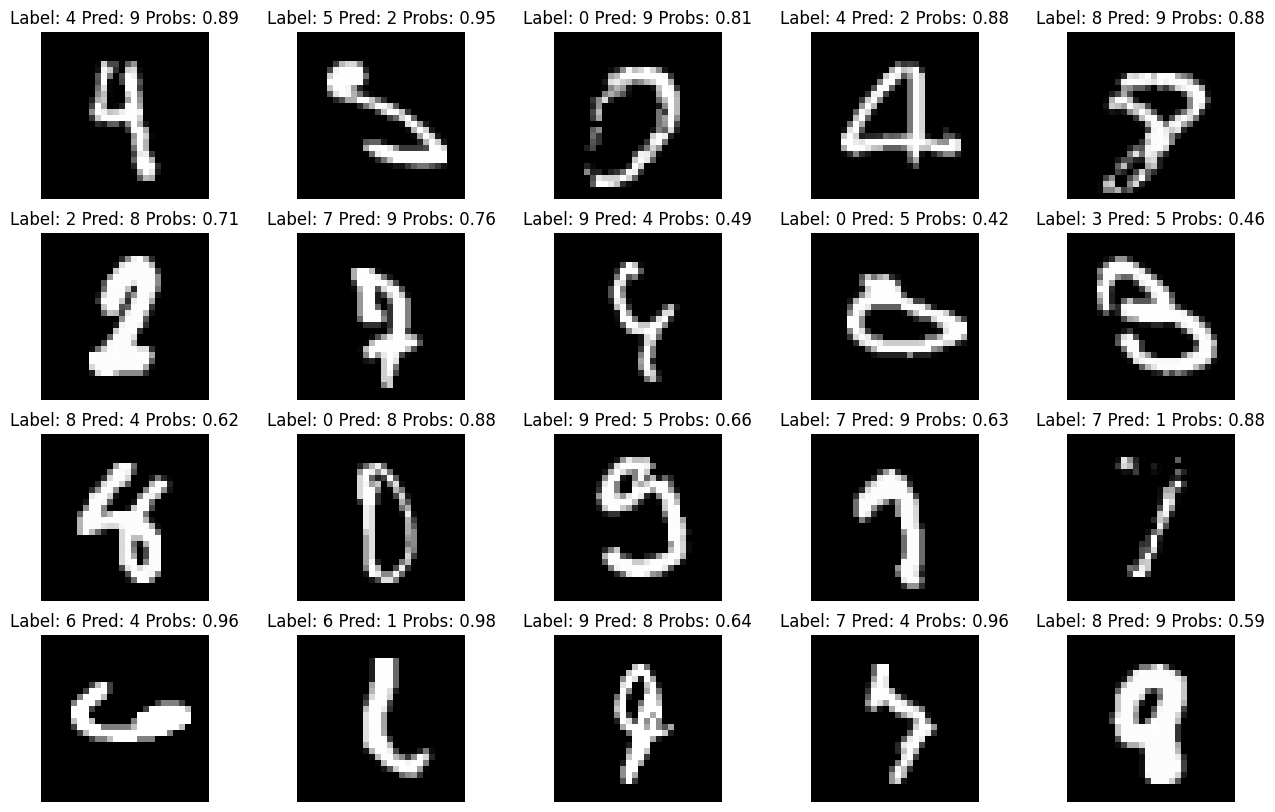

In [ ]:
# Show incorrect predictions
import random
wrong_prediction_index = torch.nonzero(preds != valid_ds.targets).squeeze(1)

fig = plt.figure(figsize=(16, 10))
rows, cols = 4, 5
for i, index in enumerate(random.sample(list(wrong_prediction_index), k=rows*cols)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(valid_ds.data[index].data, cmap='gray')
    color = 'g' if valid_ds.targets[index]==preds[index] else 'r'
    plt.title(f'Label: {valid_ds.targets[index]} Pred: {preds[index]} Probs: {round(probs[index].item(), 2)}')
    plt.axis(False)

As can see from above, the wrong predictions are difficult to differenciate even from human eyes. And they are generally of low proababilities which shows the low confidence level from the model predictions

To further understand the errors, we can plot out the confusion matrix

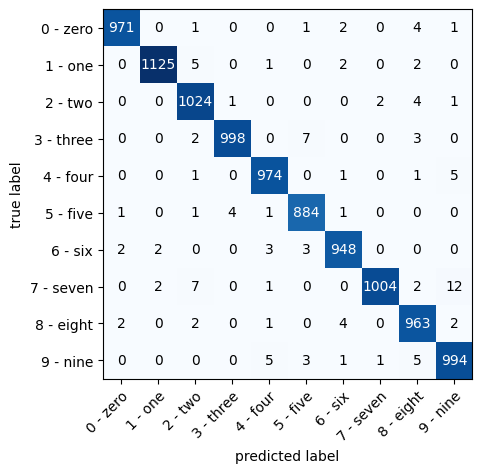

In [ ]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_pred = preds.numpy()
y_target = valid_ds.targets.numpy()

cm = confusion_matrix(y_target=y_target,
                      y_predicted=y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                class_names=valid_ds.classes)

From the confusion matrix, we can see where model get the predictions wrong. The most frequent occurence on errors are between (7, 9), (4, 9)

# Notebook Summary

1. Building a multi-layer neural network for resolving MNIST classification
2. Improving our model using convolutional layers
3. Understanding the basics of convolutional block with
    * convolutional layer
    * activation layer
    * pooling layer
4. Building a simple CNN netowrk - TinyVGG
5. Evaluating our model results by visualisation in confusion matrix